<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [669]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [670]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette='Dark2')

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [671]:
data = pd.read_csv('./train.csv')

In [672]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

---

Посмотрим на случайные 5 строчек.

In [673]:
print(data.shape)
data.sample(5)

(5282, 20)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1896,13,19.55,265.3,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3742,13,56.00,764.55,Female,0,No,Yes,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0
51,1,74.45,74.45,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
729,2,62.15,113.1,Female,0,Yes,No,Yes,No,DSL,Yes,No,No,No,No,Yes,Month-to-month,Yes,Mailed check,0
1749,66,105.65,6844.5,Male,0,No,No,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),0


Видно, что половина категориальных признаков можно закодировать бинарно.

Теперь посмотрим на наличие пропусков в данных.

In [674]:
print(data.isna().sum())
data.info()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   

Как мы видим, сумма пропусков по всем признакам равно нулю.

Но признак TotalSpent имеет тип object.
Посмотрим на значения этого признака.

In [675]:
data.TotalSpent.value_counts().head()

20.2     9
         9
19.75    8
20.05    6
19.65    6
Name: TotalSpent, dtype: int64

В девяти наблюдениях признак TotalSpent имеет значение " ".

Посмотрим на эти наблюдения

In [676]:
data[data.TotalSpent == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Видим, что эти клиенты с нами первый месяц и просто их TotalSpent пока равен нулю, так как он, обновляется в конце месяца.

Заменим пробелы на нули.

In [677]:
data.loc[data.TotalSpent == ' ', 'TotalSpent'] = 0
data.TotalSpent = pd.to_numeric(data.TotalSpent)

In [678]:
# проверим еще раз
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

---

Построим гистограммы и боксплоты для числовых признаков. 

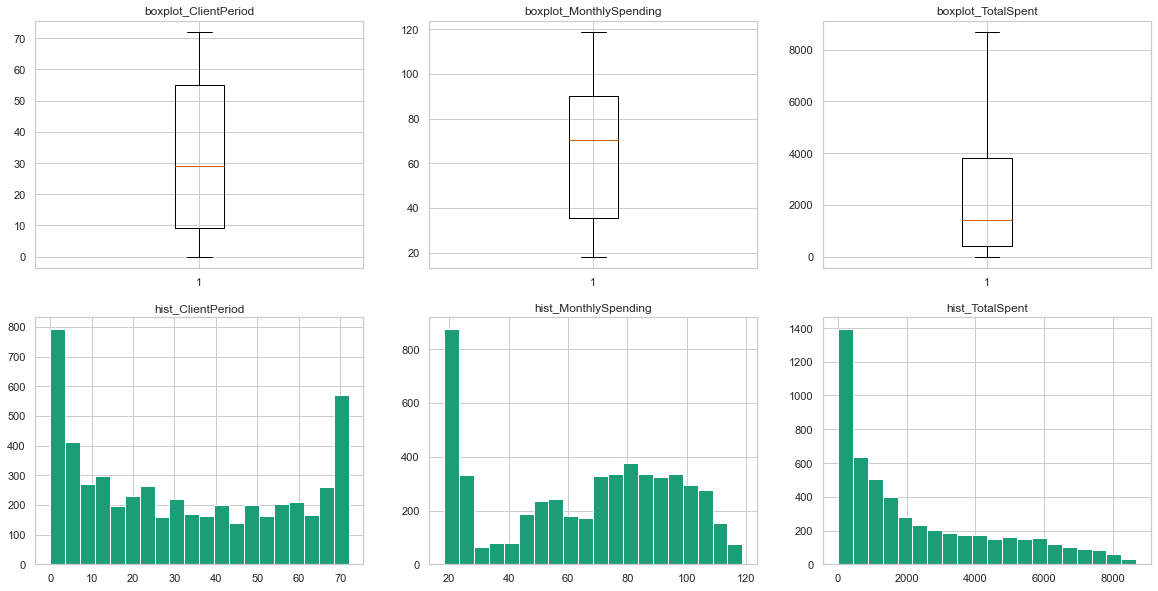

In [679]:
fig = plt.figure(figsize=(20,10))

for i in range(0, 3):
    ax = fig.add_subplot(2, 3, i+1)
    ax.boxplot(data[num_cols[i]])
    ax.set_title('boxplot_' + num_cols[i])
    ax = fig.add_subplot(2, 3, i+4)
    ax.hist(data[num_cols[i]], bins=20)
    ax.set_title('hist_' + num_cols[i])
plt.show()

Построим bar для каждого категориального признака.

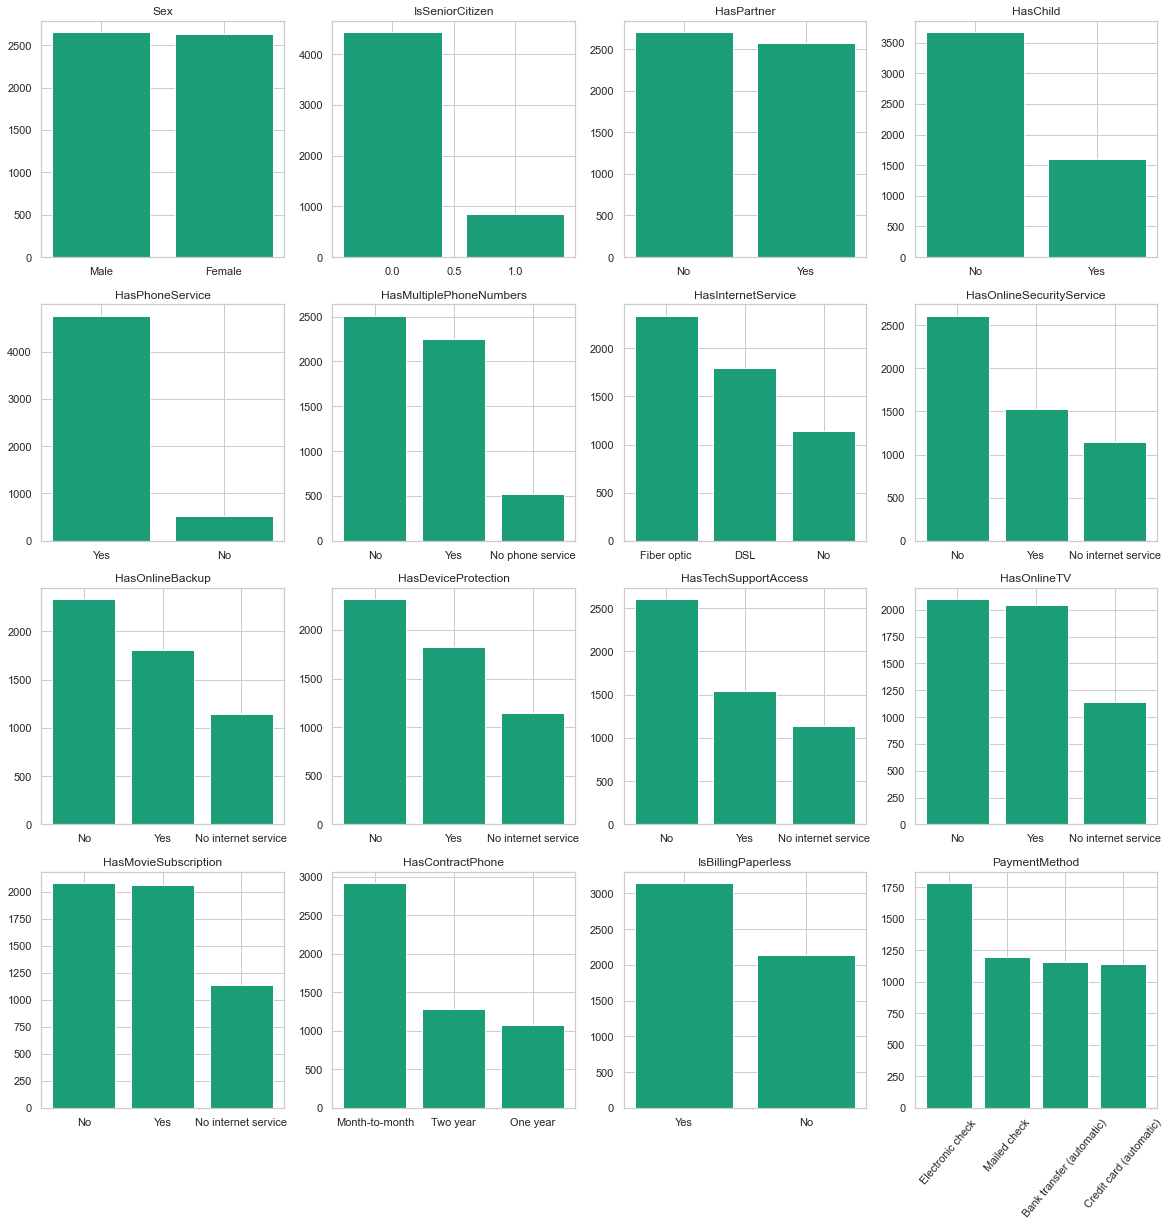

In [680]:
fig = plt.figure(figsize=(20,20))

for i in range(0, 16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.bar(data[cat_cols[i]].value_counts().index, data[cat_cols[i]].value_counts())
    ax.set_title(cat_cols[i])
    if i == 15: 
        ax.tick_params(axis='x', labelrotation=50)
plt.show()

Посмотрим на распределение целевой переменной

In [681]:
data[target_col].value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

Легко заметить, что классы являются не сбалансированными.

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [682]:
data.corr()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
ClientPeriod,1.000000,0.249414,0.826658,0.011561,-0.350640
MonthlySpending,0.249414,1.000000,0.652014,0.215456,0.184769
TotalSpent,0.826658,0.652014,1.000000,0.094640,-0.200033
IsSeniorCitizen,0.011561,0.215456,0.094640,1.000000,0.156872
Churn,-0.350640,0.184769,-0.200033,0.156872,1.000000


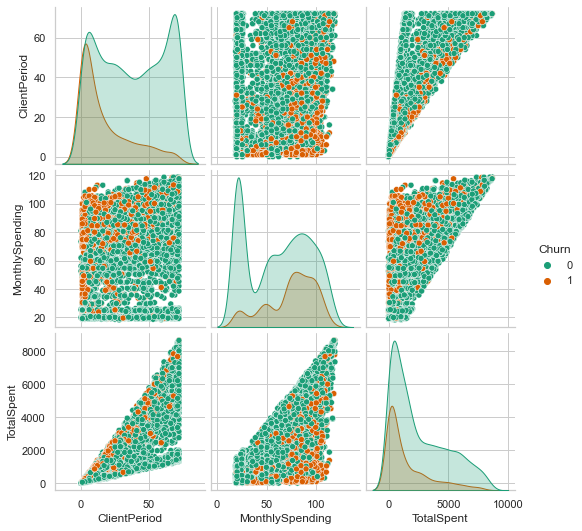

In [683]:
# построим scatter matrix для числовых признаков
sns.pairplot(data, vars=num_cols,hue=target_col)
None

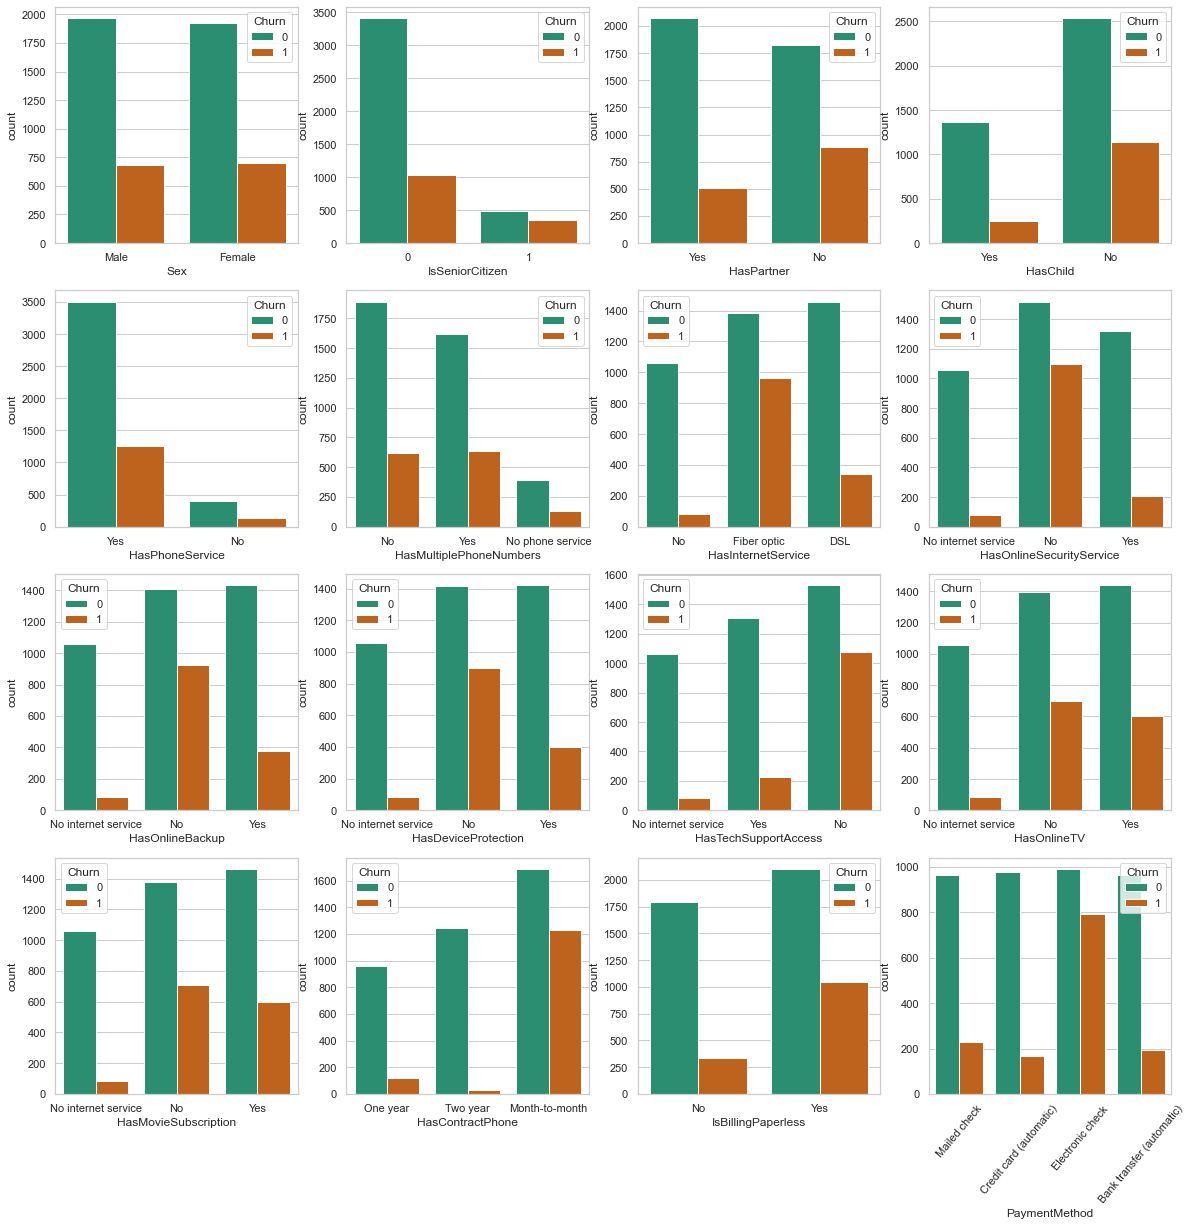

In [684]:
# построим countplot для категориальных признаков
fig = plt.figure(figsize=(20,20))

for i in range(0, 16):
    ax = fig.add_subplot(4, 4, i+1)
    sns.countplot(x = cat_cols[i], hue=target_col, data=data, ax=ax)
    if i == 15: 
        ax.tick_params(axis='x', labelrotation=50)
plt.show()

Создадим несколько признаков через нелинейные функции.

In [685]:
# новые признаки 
def preproc(data, num_cols):
    new_num_cols = []
    
    data.loc[data.TotalSpent == ' ', 'TotalSpent'] = 0
    data.TotalSpent = pd.to_numeric(data.TotalSpent)
    
    for i in range(3):
        data[num_cols[i] + '_sqr'] = data[num_cols[i]] ** 2
        new_num_cols.append(num_cols[i] + '_sqr')
        data[num_cols[i] + '_log'] = np.log(data[num_cols[i]][data[num_cols[i]]!=0])
        new_num_cols.append(num_cols[i] + '_log')
        data[num_cols[i] + '_log'].fillna(0, inplace=True)
    
    data[num_cols[0] + '_' + num_cols[1]] = data[num_cols[0]] * data[num_cols[1]]
    new_num_cols.append(num_cols[0] + '_' + num_cols[1])
    data[num_cols[0] + '_' + num_cols[2]] = data[num_cols[0]] * data[num_cols[2]]
    new_num_cols.append(num_cols[0] + '_' + num_cols[2])
    data[num_cols[1] + '_' + num_cols[2]] = data[num_cols[1]] * data[num_cols[2]]
    new_num_cols.append(num_cols[1] + '_' + num_cols[2])
    
    return data, new_num_cols

data, new_num_cols = preproc(data, num_cols)
data.isna().sum(axis=0)

c:\users\kochk\appdata\local\programs\python\python38\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


ClientPeriod                    0
MonthlySpending                 0
TotalSpent                      0
Sex                             0
IsSeniorCitizen                 0
HasPartner                      0
HasChild                        0
HasPhoneService                 0
HasMultiplePhoneNumbers         0
HasInternetService              0
HasOnlineSecurityService        0
HasOnlineBackup                 0
HasDeviceProtection             0
HasTechSupportAccess            0
HasOnlineTV                     0
HasMovieSubscription            0
HasContractPhone                0
IsBillingPaperless              0
PaymentMethod                   0
Churn                           0
ClientPeriod_sqr                0
ClientPeriod_log                0
MonthlySpending_sqr             0
MonthlySpending_log             0
TotalSpent_sqr                  0
TotalSpent_log                  0
ClientPeriod_MonthlySpending    0
ClientPeriod_TotalSpent         0
MonthlySpending_TotalSpent      0
dtype: int64

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [709]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

In [710]:
x_data = data.drop(target_col, axis=1)
y_data = data[target_col]

In [711]:
# опишем функцию которая будет создавать pipeline с нужной нам моделью
def my_make_pipeline(model, num_cols, cat_cols):
    # трансформер для численных данных
    numTransformer = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())
    ])

    # трансформер для категориальных признаков
    catTransformer = OneHotEncoder(handle_unknown='ignore')

    # соединяем в отдельный трансформер для обоих видов признаков
    preprocessor = ColumnTransformer(transformers=[
        ('num', numTransformer, num_cols),
        ('cat', catTransformer, cat_cols)
    ])

    # создаем пайплайн с препроцессором и моделью
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return clf

In [712]:
# сетка параметров
params = {'classifier__C': [100, 50, 25, 10, 1, 70],
          'classifier__penalty': ['l2', 'none'],
          'classifier__solver': ['newton-cg'],
          'classifier__max_iter':[100,300,500,1000]
         }

# инициализируем наш pipeline
clf = my_make_pipeline(LogisticRegression(), num_cols=num_cols+new_num_cols, cat_cols=cat_cols)

# инициализируем gridSearch
pl = GridSearchCV(estimator=clf, 
                   param_grid=params, 
                   scoring='roc_auc', 
                   n_jobs=-1, 
                   cv=5, 
                   verbose=True)
pl.fit(x_data, y_data)
None

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [713]:
print("Best params: {}".format(str(pl.best_params_)[1:-1]))
print("Best score: {}".format(pl.best_score_))

Best params: 'classifier__C': 25, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'
Best score: 0.8489249226576778


При параметрах C = 25, max_iter = 100, penalty = l2, solver = newton-cg 
мы получаем результат 0.8489

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [691]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [692]:
X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, train_size=0.8)

cbs = CatBoostClassifier(cat_features=cat_cols, silent=True)
cbs.fit(X_train, y_train)
y_score = cbs.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_score)

0.8549641794127865

Со стандартными параметрами catboost выдает скор 0.836

Попробуем найти наиболее качественные параметры через метод .grid_search()

In [699]:
cbs = CatBoostClassifier()

grid = {'learning_rate': [0.01, 0.1, 0.5],
        'num_trees': [100,300,500,1000],
        'depth': [3, 6, 8, 10],
        'l2_leaf_reg': [1,3,5],
        }

grid_search_result = cbs.grid_search(grid, 
                                     train_data,
                                     cv=5)


bestTest = 0.4522973863
bestIteration = 99

0:	loss: 0.4522974	best: 0.4522974 (0)	total: 1.58s	remaining: 3m 46s

bestTest = 0.3767812439
bestIteration = 96

1:	loss: 0.3767812	best: 0.3767812 (1)	total: 3.15s	remaining: 3m 43s

bestTest = 0.3804979615
bestIteration = 13

2:	loss: 0.3804980	best: 0.3767812 (1)	total: 4.7s	remaining: 3m 40s

bestTest = 0.4493779477
bestIteration = 99

3:	loss: 0.4493779	best: 0.3767812 (1)	total: 6.32s	remaining: 3m 41s

bestTest = 0.3761966929
bestIteration = 97

4:	loss: 0.3761967	best: 0.3761967 (4)	total: 7.86s	remaining: 3m 38s

bestTest = 0.3829521214
bestIteration = 26

5:	loss: 0.3829521	best: 0.3761967 (4)	total: 9.56s	remaining: 3m 39s

bestTest = 0.4575668927
bestIteration = 99

6:	loss: 0.4575669	best: 0.3761967 (4)	total: 11.2s	remaining: 3m 39s

bestTest = 0.3759572645
bestIteration = 93

7:	loss: 0.3759573	best: 0.3759573 (7)	total: 12.9s	remaining: 3m 38s

bestTest = 0.3871936559
bestIteration = 32

8:	loss: 0.3871937	best: 0.3759573 (


bestTest = 0.3791353869
bestIteration = 132

70:	loss: 0.3791354	best: 0.3744472 (10)	total: 19m 15s	remaining: 19m 47s

bestTest = 0.3834676777
bestIteration = 13

71:	loss: 0.3834677	best: 0.3744472 (10)	total: 20m 2s	remaining: 20m 2s

bestTest = 0.4351089365
bestIteration = 99

72:	loss: 0.4351089	best: 0.3744472 (10)	total: 20m 7s	remaining: 19m 34s

bestTest = 0.3849825684
bestIteration = 62

73:	loss: 0.3849826	best: 0.3744472 (10)	total: 20m 12s	remaining: 19m 6s

bestTest = 0.3872400949
bestIteration = 4

74:	loss: 0.3872401	best: 0.3744472 (10)	total: 20m 17s	remaining: 18m 40s

bestTest = 0.4351319732
bestIteration = 99

75:	loss: 0.4351320	best: 0.3744472 (10)	total: 20m 22s	remaining: 18m 13s

bestTest = 0.3822949352
bestIteration = 49

76:	loss: 0.3822949	best: 0.3744472 (10)	total: 20m 27s	remaining: 17m 47s

bestTest = 0.3851242265
bestIteration = 7

77:	loss: 0.3851242	best: 0.3744472 (10)	total: 20m 32s	remaining: 17m 23s

bestTest = 0.4394148852
bestIteration = 99




bestTest = 0.3916500636
bestIteration = 49

139:	loss: 0.3916501	best: 0.3744472 (10)	total: 52m 23s	remaining: 1m 29s

bestTest = 0.4068613106
bestIteration = 3

140:	loss: 0.4068613	best: 0.3744472 (10)	total: 53m 33s	remaining: 1m 8s

bestTest = 0.3846677469
bestIteration = 464

141:	loss: 0.3846677	best: 0.3744472 (10)	total: 54m 30s	remaining: 46.1s

bestTest = 0.3919293978
bestIteration = 32

142:	loss: 0.3919294	best: 0.3744472 (10)	total: 55m 40s	remaining: 23.4s

bestTest = 0.4005127098
bestIteration = 13

143:	loss: 0.4005127	best: 0.3744472 (10)	total: 56m 50s	remaining: 0us
Estimating final quality...


In [700]:
best_params = grid_search_result.get('params')
best_params

{'depth': 3, 'l2_leaf_reg': 1, 'iterations': 300, 'learning_rate': 0.1}

Лучшие параметры = {'depth': 3, 'l2_leaf_reg': 1, 'iterations': 300, 'learning_rate': 0.1}

In [701]:
cb_best = CatBoostClassifier(iterations=300,
                        depth=3,
                        learning_rate=0.1,
                        random_seed=42,
                        l2_leaf_reg = 1,
                        custom_metric='AUC:hints=skip_train~false',
                        cat_features=cat_cols)

cb_best.fit(x_data, y_data)

0:	learn: 0.6448195	total: 14.4ms	remaining: 4.3s
1:	learn: 0.6077584	total: 29ms	remaining: 4.33s
2:	learn: 0.5758637	total: 62ms	remaining: 6.13s
3:	learn: 0.5519032	total: 92.9ms	remaining: 6.87s
4:	learn: 0.5332319	total: 125ms	remaining: 7.36s
5:	learn: 0.5150278	total: 157ms	remaining: 7.71s
6:	learn: 0.4981578	total: 174ms	remaining: 7.3s
7:	learn: 0.4843958	total: 203ms	remaining: 7.39s
8:	learn: 0.4721391	total: 251ms	remaining: 8.13s
9:	learn: 0.4641617	total: 283ms	remaining: 8.21s
10:	learn: 0.4566657	total: 314ms	remaining: 8.24s
11:	learn: 0.4513568	total: 345ms	remaining: 8.28s
12:	learn: 0.4461571	total: 378ms	remaining: 8.33s
13:	learn: 0.4429649	total: 410ms	remaining: 8.38s
14:	learn: 0.4400325	total: 430ms	remaining: 8.18s
15:	learn: 0.4364923	total: 457ms	remaining: 8.11s
16:	learn: 0.4337181	total: 485ms	remaining: 8.08s
17:	learn: 0.4312398	total: 517ms	remaining: 8.1s
18:	learn: 0.4289058	total: 559ms	remaining: 8.26s
19:	learn: 0.4254448	total: 577ms	remaining:

164:	learn: 0.3897579	total: 5.12s	remaining: 4.19s
165:	learn: 0.3896769	total: 5.14s	remaining: 4.15s
166:	learn: 0.3896481	total: 5.19s	remaining: 4.13s
167:	learn: 0.3896445	total: 5.21s	remaining: 4.09s
168:	learn: 0.3894079	total: 5.24s	remaining: 4.06s
169:	learn: 0.3893761	total: 5.26s	remaining: 4.02s
170:	learn: 0.3890980	total: 5.27s	remaining: 3.98s
171:	learn: 0.3888414	total: 5.29s	remaining: 3.94s
172:	learn: 0.3887606	total: 5.32s	remaining: 3.9s
173:	learn: 0.3887324	total: 5.35s	remaining: 3.88s
174:	learn: 0.3885030	total: 5.38s	remaining: 3.84s
175:	learn: 0.3884256	total: 5.41s	remaining: 3.81s
176:	learn: 0.3883321	total: 5.44s	remaining: 3.78s
177:	learn: 0.3882998	total: 5.48s	remaining: 3.75s
178:	learn: 0.3881197	total: 5.49s	remaining: 3.71s
179:	learn: 0.3881196	total: 5.52s	remaining: 3.68s
180:	learn: 0.3880563	total: 5.56s	remaining: 3.65s
181:	learn: 0.3880187	total: 5.59s	remaining: 3.62s
182:	learn: 0.3878632	total: 5.63s	remaining: 3.6s
183:	learn: 0.

In [702]:
cb.get_best_score()

{'learn': {'Logloss': 0.37543403312915963, 'AUC': 0.8771654057067949}}

---

Лучшее качество получилось на CatBoost

С параметрами: {'depth': 3, 'l2_leaf_reg': 1, 'iterations': 300, 'learning_rate': 0.1}

Оценка при этом: 0.8772

# Предсказания

In [703]:
best_model = cb_best
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

X_test, _ = preproc(X_test, num_cols)

In [704]:
best_model.predict_proba(X_test)[:,1]

array([0.02627618, 0.6618065 , 0.63742375, ..., 0.82097737, 0.49687442,
       0.00952103])

In [705]:
best_model.predict(X_test)

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [708]:
submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

Итоговая оценка на тестовых данных на kaggle - 0.85425

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.